In [6]:
# Get an A100 high memory instance Premium +
# Get repo, change to bin directory, 
!git lfs install
!cd /content
!git clone https://github.com/retospect/proteoxystis.git
%cd ~
%cd /content/proteoxystis/bin
%pwd
!git checkout 16bitfloat
# install dependencies
!pip install -r requirements.txt

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
fatal: destination path 'proteoxystis' already exists and is not an empty directory.
/root
/content/proteoxystis/bin
Branch '16bitfloat' set up to track remote branch '16bitfloat' from 'origin'.
Switched to a new branch '16bitfloat'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# Prep data if needed.
!python3 ./pickelize.py

Reading toml file
Removing stupid data
 99% 70287/70896 [00:00<00:00, 95368.57it/s] 
after removing stupid data, this many remain  70287
Input array size (pdb x one-hot sequence):  (70287, 4128, 21)
Filling sequence array
100% 70287/70287 [00:10<00:00, 6829.99it/s]
Normalizing output values
  5% 17/349 [00:00<00:15, 21.05it/s]/content/proteoxystis/bin/./pickelize.py:114: RuntimeWarning: overflow encountered in true_divide
  values = values / factor
/content/proteoxystis/bin/./pickelize.py:116: RuntimeWarning: invalid value encountered in subtract
  values = values - offset
100% 349/349 [00:17<00:00, 20.43it/s]
Output array size (pdb x one-hot output):  (70287, 698)
Filling output array
100% 70287/70287 [00:15<00:00, 4513.38it/s]
Reading test data from test.toml
Separating test data from training data
100% 70287/70287 [00:09<00:00, 7692.02it/s]
Test data size:  (17571, 4128, 21)
Training data size:  (52716, 4128, 21)
Pickeling data


From class example:


In [10]:
%cd /content/proteoxystis/bin
!pwd
!ls
# Load data:
import pickle

print("Loading data...", end="", flush=True)
# gzip the pickle is possible but way slow
with open("training_data.pickle", "rb") as f:
    (
        metadata,
        seqs,
        output,
        seqs_test,
        output_test,
        relevant_train,
        relevant_test,
    ) = pickle.load(f)
print("done")



/content/proteoxystis/bin
/content/proteoxystis/bin
data			pdb-few.toml	      tests
datawrangling.md	pdb-few.toml.gz       test.toml
encoding.py		pdb-parsing-bugs.txt  tidy.py
extract.py		pdb.toml.gz	      training_data.pickle
interesting_pdbids.txt	pickelize.py	      training.toml
model			requirements.txt      TrainOnColab.ipynb
pdb.err.gz		seq-exp.ipynb	      train.py
Loading data...done


In [56]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, llm_layers, llm_dropout, linear_hidden_size, n_linear, linear_dropout, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, linear_hidden_size, num_layers=llm_layers, batch_first=True,dropout=llm_dropout)
        self.linear = []
        self.softmax = []
        self.dropout = []
        for i in range(n_linear):
          self.linear.append(torch.nn.Linear(linear_hidden_size,linear_hidden_size))
          self.softmax.append(torch.nn.Softmax())
          self.dropout.append(torch.nn.Dropout(linear_dropout))

       
        self.linearEnd = torch.nn.Linear(linear_hidden_size, output_size)
        print("Hidden size", hidden_size)
        print("output size", output_size)
        print("input size", input_size)
    def to(self, device):
      super().to(device)
      for l, s, d in zip(self.linear, self.softmax, self.dropout):
        l.to(device)
        s.to(device)
        d.to(device)
    def forward(self, x):
        x = self.lstm(x)[0]
        for l, s, d in zip(self.linear, self.softmax, self.dropout):
          x = l(x)
          x = s(x)
          x = d(x)
        x = self.linearEnd(x)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

In [57]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx in range(len(train_data_gen)):
        if batch_idx%25 ==0:
          print(",", end="", flush=True)
        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target, mask = train_data_gen[batch_idx]
        data, target, mask = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device), torch.from_numpy(mask).float().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①
        
        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]
        output = mask*output
        
        #output = mask*output#
        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)
        #print(output.shape, target.shape)
        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()
    print(":", end="", flush=True)
    return num_correct, loss.item()

In [22]:
def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target, mask = test_data_gen[batch_idx]
            data, target, mask = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device), torch.from_numpy(mask).float().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]
            output = mask * output
            #output =mask*output
            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

In [23]:
import matplotlib.pyplot as plt
#from res.plot_lib import set_default, plot_state, print_colourbar
#set_default()

In [59]:
import numpy as np
def getTrainGen():

    from torch.utils.data import TensorDataset, DataLoader
    import torch
    setlen = 256
    #print("len",len(seqs))
    np.random.shuffle(seqs)
    numpieces = len(seqs)//setlen
    longbit = numpieces*setlen
    #print("pcs",numpieces)
    ##print(len(seqs))
    #print(longbit)
    seqs2,_ = np.split(seqs, [longbit])
    output2,_ = np.split(output, [longbit])
    relevant_train2,_ = np.split(relevant_train, [longbit])
    seqs2 = np.split(seqs2,setlen)
    output2 = np.split(output2, setlen)
    relevant_train2 = np.split(relevant_train2, setlen)

    #print(len(output2))
    trainy = []
    for i in range(setlen):
       trainy.append((seqs2[i], output2[i], relevant_train2[i]))
    return trainy


In [54]:
def train_and_test(model, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("On ", device)
    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        train_data_gen = getTrainGen()
        #train_data_gen.to(device)
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) ) #fixme
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) ) #FIXME
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        print(f'\n[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

In [50]:
import numpy as np

## Test

setlen = 256
print(len(seqs_test))
numpieces = len(seqs_test)//setlen
longbit = numpieces*setlen
print(numpieces)
print(len(seqs_test))
print(longbit)
seqs2,_ = np.split(seqs_test, [longbit])
output2,_ = np.split(output_test, [longbit])
relevant_train2,_ = np.split(relevant_train, [longbit])
seqs2 = np.split(seqs2,setlen)
output2 = np.split(output2, setlen)
relevant_test2,_ = np.split(relevant_train2, [longbit])
print(len(output2))
testy = []
for i in range(setlen):
  testy.append((seqs2[i], output2[i], relevant_test2[i]))


17571
68
17571
17408
256


Hidden size 3
output size 698
input size 21
On  cuda:0
,

<ipython-input-56-9b4898c2f015>:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = s(x)


,,,,,,,,,,:
[Epoch 1/15] loss: 6.0595, acc: 44.57% - test_loss: 6.1987, test_acc: 34.94%
,,,,,,,,,,,:
[Epoch 2/15] loss: 5.7323, acc: 158.19% - test_loss: 5.9434, test_acc: 37.57%
,,,,,,,,,,,:
[Epoch 3/15] loss: 5.4246, acc: 153.80% - test_loss: 5.7066, test_acc: 38.97%
,,,,,,,,,,,:
[Epoch 4/15] loss: 5.1306, acc: 142.36% - test_loss: 5.4844, test_acc: 42.42%
,,,,,,,,,,,:
[Epoch 5/15] loss: 4.8518, acc: 141.89% - test_loss: 5.2808, test_acc: 42.42%
,,,,,,,,,,,:
[Epoch 6/15] loss: 4.5829, acc: 141.89% - test_loss: 5.0915, test_acc: 42.42%
,,,,,,,,,,,:
[Epoch 7/15] loss: 4.3223, acc: 141.89% - test_loss: 4.9032, test_acc: 42.42%
,,,,,,,,,,,:
[Epoch 8/15] loss: 4.0708, acc: 141.91% - test_loss: 4.7297, test_acc: 42.42%
,,,,,,,,,,,:
[Epoch 9/15] loss: 3.8299, acc: 141.92% - test_loss: 4.5701, test_acc: 42.42%
,,,,,,,,,,,:
[Epoch 10/15] loss: 3.5940, acc: 135.13% - test_loss: 4.4077, test_acc: 43.06%
,,,,,,,,,,,:
[Epoch 11/15] loss: 3.3636, acc: 131.89% - test_loss: 4.2581, test_acc: 43.11%

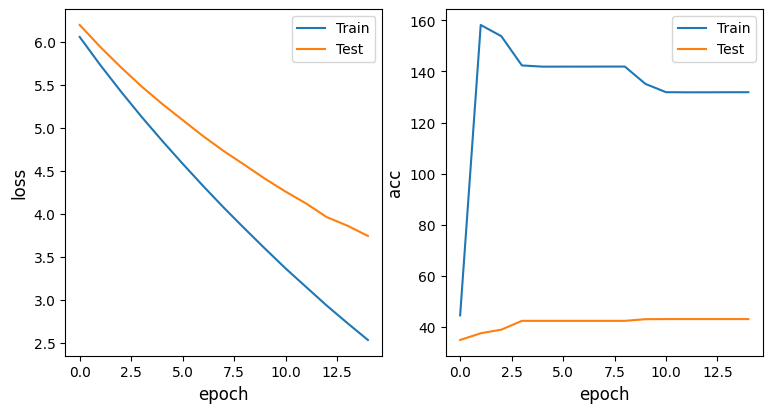

In [60]:
input_size = 4128
# Setup the RNN and training settings
input_size  = 21 
hidden_size = 3
output_size = 698
     #def __init__(self, input_size, llm_layers, llm_dropout, linear_hidden_size, n_linear, linear_dropout, output_size):
model       = SimpleLSTM(21, 3, .3, 8, 10, .3, output_size)
criterion   = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.MSELoss()#
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 15

# Train the model
model = train_and_test(model, testy, criterion, optimizer, max_epochs, verbose=False)

In [ ]:
torch.save(model, "lstm-model-cel.pt")

In [48]:
from __future__ import print_function
from sys import getsizeof, stderr, getsizeof
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)


##### Example call #####

for name, size in sorted(((name, total_size(value, verbose=False)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      metadata:  4.2 MiB
                         testy: 114.1 KiB
                           _ih: 51.0 KiB
                            In: 51.0 KiB
                         seqs2: 38.1 KiB
                       output2: 34.1 KiB
                          _i12:  4.6 KiB
                          _i21:  4.6 KiB
                          _i11:  2.4 KiB
                          _i29:  2.4 KiB
                          _i20:  2.4 KiB
                          _i31:  2.4 KiB
                           _ii:  2.3 KiB
                          _i46:  2.3 KiB
                          _i44:  2.3 KiB
                          _i43:  2.3 KiB
                          _i48:  2.2 KiB
                          _i16:  2.1 KiB
                          _i25:  2.1 KiB
                          _i33:  2.0 KiB
